# import libiraries

In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast


# Data Collection

 load dataset & check columns

In [56]:
dataset_path_1 = 'tmdb_5000_movie.csv'

df_1 = pd.read_csv(dataset_path_1)


print(df_1.columns)


Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')


In [57]:
dataset_path_2 = 'tmdb_5000_credits.csv'

df_2 = pd.read_csv(dataset_path_2)


print(df_2.columns)

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')


merge two files 

In [58]:
import pandas as pd


#  if title  is a common column 
if 'title' in df_1.columns and 'title' in df_2.columns:
    # Merge 
    merged_df = pd.merge(df_1, df_2, on='title', how='inner')

print (merged_df.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')


# Data Cleaning 


handel missing data

In [59]:
# Check for missing values
missing_values = merged_df.isnull().sum()
# so .....
merged_df = merged_df.drop(columns=['homepage'])
merged_df = merged_df.dropna(subset=['overview'])
most_common_release_date = merged_df['release_date'].mode()[0]
merged_df['release_date'].fillna(most_common_release_date, inplace=True)
median_runtime = merged_df['runtime'].median()
merged_df['runtime'].fillna(median_runtime, inplace=True)
merged_df = merged_df.drop(columns=['tagline'])



Removing Duplicates

In [60]:
merged_df = merged_df.drop_duplicates()


# Feature Engineering

In [61]:
#  One-hot encode genres & spoken languages
merged_df = pd.get_dummies(merged_df, columns=['genres'], prefix='genre')
merged_df = pd.get_dummies(merged_df, columns=['spoken_languages'], prefix='language')


For Numeric Features

In [62]:


# Min-Max scaling for 'budget' and 'popularity'
scaler = MinMaxScaler()
merged_df[['budget', 'popularity']] = scaler.fit_transform(merged_df[['budget', 'popularity']])


# Exploratory Data Analysis (EDA)

Visualize Data

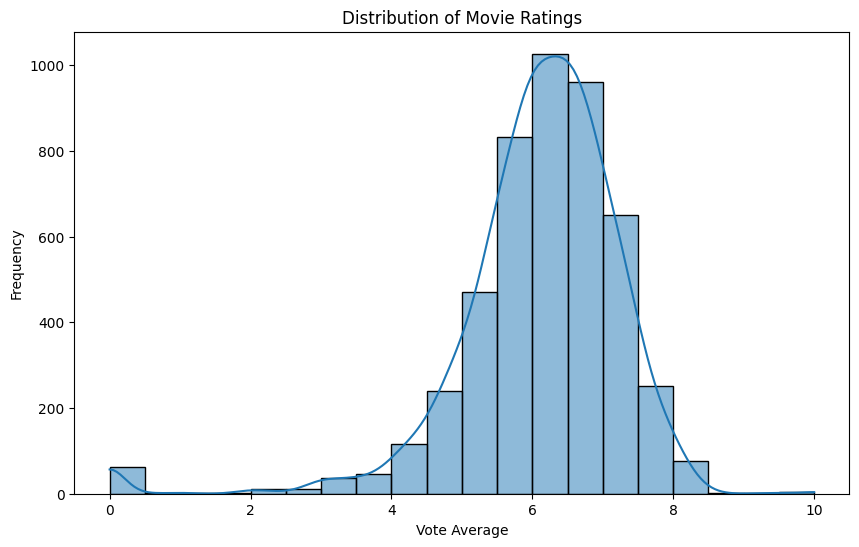

In [63]:

# Plot a histogram 
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='vote_average', bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()


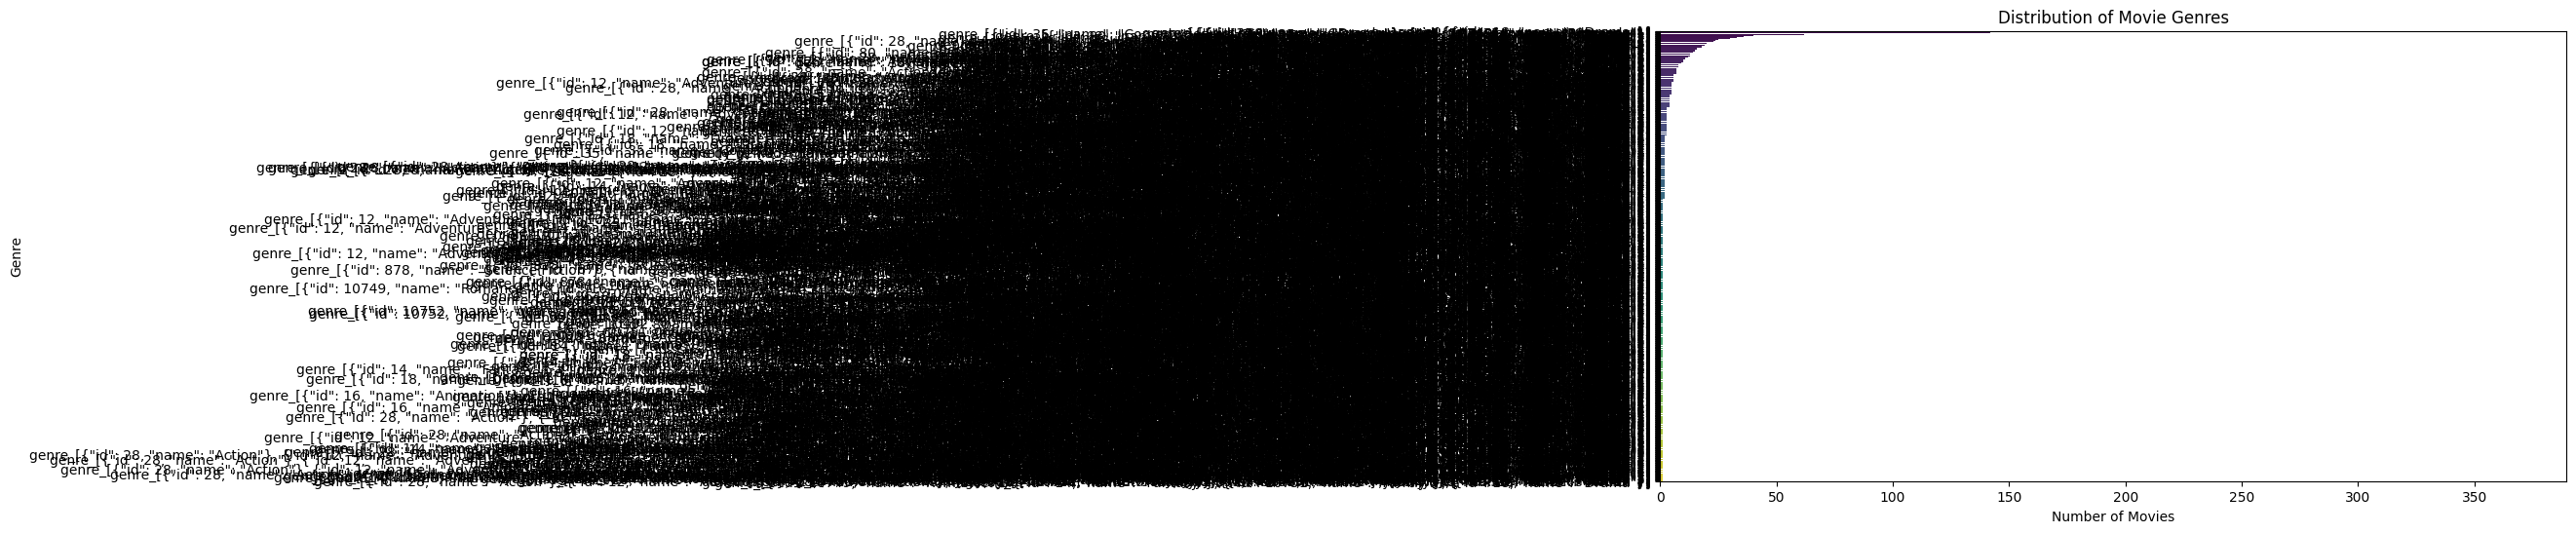

In [64]:
#  genre distribution
#Bar chart 
genre_counts = merged_df.filter(like='genre_').sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


Summary statistics for Numerical Columns

In [65]:

summary_stats = merged_df[['vote_average', 'vote_count']].describe()
print(summary_stats)


       vote_average    vote_count
count   4806.000000   4806.000000
mean       6.093258    690.758427
std        1.190846   1234.454061
min        0.000000      0.000000
25%        5.600000     54.000000
50%        6.200000    236.000000
75%        6.800000    737.750000
max       10.000000  13752.000000


Line plot for average rating over time 

C:\Users\Softlaptop\AppData\Local\Temp\ipykernel_13572\619001037.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=merged_df, x='release_year', y='vote_average', ci=None)


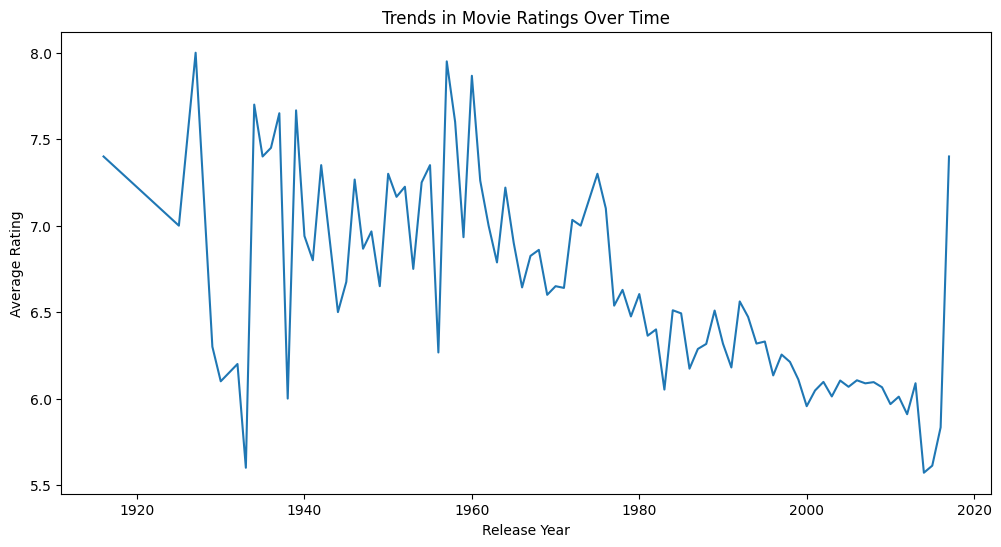

In [66]:
merged_df['release_year'] = merged_df['release_date'].str.extract(r'(\d{4})').astype(float)
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='release_year', y='vote_average', ci=None)
plt.title('Trends in Movie Ratings Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.show()


Scatter plot to explore the relationship

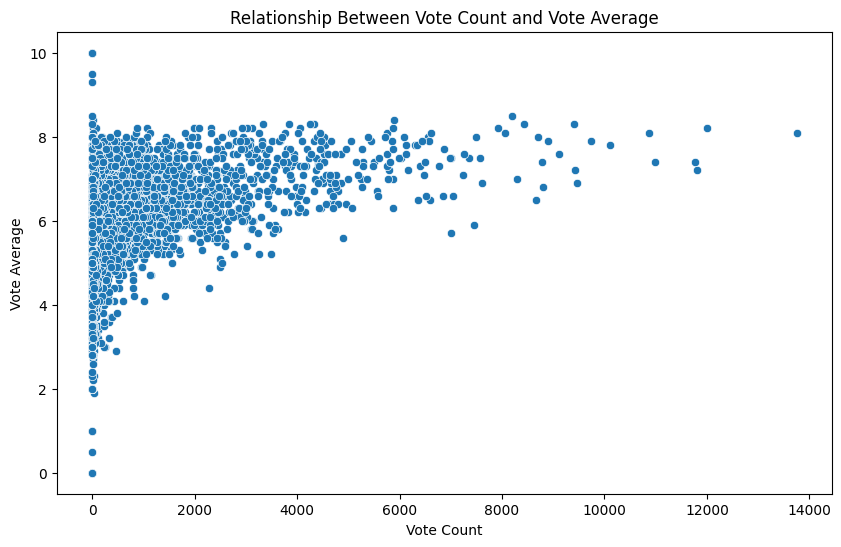

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='vote_count', y='vote_average')
plt.title('Relationship Between Vote Count and Vote Average')
plt.xlabel('Vote Count')
plt.ylabel('Vote Average')
plt.show()


# collaborative filtering

user-based collaborative filtering

In [ ]:
import numpy as np
import pandas as pd

#i made this algorithm but my data have not rating and also user and actuaaly not invalid for collaborative filtering so i will skip to content-based movie recommendations
user_column_name = 'user_id'
movie_column_name = 'movie_id'
rating_column_name = 'rating'

user_item_matrix = merged_df.pivot(index=user_column_name, columns=movie_column_name, values=rating_column_name).fillna(0)

def cosine_similarity(matrix):
    similarity_matrix = np.zeros((matrix.shape[0], matrix.shape[0]))
    for i in range(matrix.shape[0]):
        for j in range(i, matrix.shape[0]):
            dot_product = np.dot(matrix[i], matrix[j])
            norm_i = np.linalg.norm(matrix[i])
            norm_j = np.linalg.norm(matrix[j])
            similarity = dot_product / (norm_i * norm_j)
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity
    return similarity_matrix

user_similarity_matrix = cosine_similarity(user_item_matrix.values)


def user_based_recommendation(user_id, user_similarity, user_item_matrix, num_recommendations):
    user_ratings = user_item_matrix.iloc[user_id]
    weighted_ratings = np.dot(user_similarity[user_id], user_item_matrix.values)
    

    rated_indices = np.where(user_ratings > 0)[0]
    weighted_ratings[rated_indices] = -1
    

    top_indices = np.argsort(weighted_ratings)[::-1][:num_recommendations]
    
    return top_indices


user_id = 0  
num_recommendations = 3
recommendations = user_based_recommendation(user_id, user_similarity_matrix, user_item_matrix, num_recommendations)


print("Recommended movie indices:", recommendations)


# content-based movie recommendations

Content-Based Filtering with Movie Genres



In [73]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load movie data
df_1 = pd.read_csv('tmdb_5000_credits.csv')
df_2 = pd.read_csv('tmdb_5000_movie.csv')

# Merge the two datasets on the 'title' column
movies = df_1.merge(df_2, on='title')

movies = movies[['title', 'overview', 'genres', 'keywords', 'cast', 'crew']]

def extract_names(text):
    names = []
    for item in ast.literal_eval(text):
        names.append(item['name'])
    return names

# Apply the function to 'genres', 'keywords', 'cast', and 'crew' columns
for column in ['genres', 'keywords', 'cast', 'crew']:
    movies[column] = movies[column].apply(extract_names)

# Preprocess data by removing spaces and converting to lowercase
def preprocess(text_list):
    return [name.replace(" ", "").lower() for name in text_list]

for column in ['genres', 'keywords', 'cast', 'crew']:
    movies[column] = movies[column].apply(preprocess)

# Create a new 'tags' column by combining all relevant features
movies['tags'] = movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

cv = CountVectorizer(max_features=5000, stop_words='english')
tag_matrix = cv.fit_transform(movies['tags'].apply(lambda x: ' '.join(x)))

cosine_sim = cosine_similarity(tag_matrix, tag_matrix)

# Create a DataFrame with movie titles and their corresponding indices
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def recommend(movie_title, num_recommendations=7):
    idx = indices[movie_title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


    sim_indices = [i[0] for i in sim_scores[1:num_recommendations + 1]]


    recommended_movies = movies.iloc[sim_indices][['title', 'overview']]

    return recommended_movies
recommendations = recommend('Spider-Man 3', num_recommendations=7)

print("Recommended Movies for 'The Lego Movie':")
for index, row in recommendations.iterrows():
    print(f"Title: {row['title']}")
    print(f"Overview: {row['overview']}\n")


Recommended Movies for 'The Lego Movie':
Title: Spider-Man 2
Overview: Peter Parker is going through a major identity crisis. Burned out from being Spider-Man, he decides to shelve his superhero alter ego, which leaves the city suffering in the wake of carnage left by the evil Doc Ock. In the meantime, Parker still can't act on his feelings for Mary Jane Watson, a girl he's loved since childhood.

Title: Spider-Man
Overview: After being bitten by a genetically altered spider, nerdy high school student Peter Parker is endowed with amazing powers.

Title: The Amazing Spider-Man
Overview: Peter Parker is an outcast high schooler abandoned by his parents as a boy, leaving him to be raised by his Uncle Ben and Aunt May. Like most teenagers, Peter is trying to figure out who he is and how he got to be the person he is today. As Peter discovers a mysterious briefcase that belonged to his father, he begins a quest to understand his parents' disappearance – leading him directly to Oscorp and th

In [81]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def user_interface():
    print("Welcome to the Movie Recommendation System!")

    while True:
        print("\nOptions:")
        print("1. Get movie recommendations")
        print("2. Exit")
        
        choice = input("Please select an option (1/2): ")

        if choice == '1':
            movie_title = input("Enter the title of the movie you like: ")
            num_recommendations = int(input("How many recommendations would you like? "))
            
            try:
                recommendations = recommend(movie_title, num_recommendations)
                
                print(f"\nRecommended Movies for '{movie_title}':")
                for index, row in recommendations.iterrows():
                    print(f"Title: {row['title']}")
                    print(f"Overview: {row['overview']}\n")
            except KeyError:
                print("Movie not found in the database. Please try again.")

        elif choice == '2':
            print("Thank you for using the Movie Recommendation System. Goodbye!")
            break

        else:
            print("Invalid choice. Please select a valid option.")

if __name__ == "__main__":
    user_interface()


Welcome to the Movie Recommendation System!

Options:
1. Get movie recommendations
2. Exit



Recommended Movies for 'Spider-Man 3':
Title: Spider-Man 2
Overview: Peter Parker is going through a major identity crisis. Burned out from being Spider-Man, he decides to shelve his superhero alter ego, which leaves the city suffering in the wake of carnage left by the evil Doc Ock. In the meantime, Parker still can't act on his feelings for Mary Jane Watson, a girl he's loved since childhood.

Title: Spider-Man
Overview: After being bitten by a genetically altered spider, nerdy high school student Peter Parker is endowed with amazing powers.

Title: The Amazing Spider-Man
Overview: Peter Parker is an outcast high schooler abandoned by his parents as a boy, leaving him to be raised by his Uncle Ben and Aunt May. Like most teenagers, Peter is trying to figure out who he is and how he got to be the person he is today. As Peter discovers a mysterious briefcase that belonged to his father, he begins a quest to understand his parents' disappearance – leading him directly to Oscorp and the